In [16]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100.0%

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw


83.3%

1.5%0%

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw


159.1%/usr/local/anaconda3/envs/pytorch/lib/python3.9/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /tmp/pip-req-build-x1rp5px8/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw
Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw
Processing...
Done!


In [3]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


In [4]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cpu device


In [69]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU()
        )

        self.conv_stack = nn.Sequential(
            nn.Conv2d(28*28, 32, kernel_size=5, padding=4, padding_mode="zeros"),
            nn.ReLU(),
            #nn.MaxPool2d(kernel_size=2),
            #nn.Dropout(0.25),

            nn.Flatten(),
            nn.Linear(32*28*28, 10),
            nn.ReLU(),
            nn.LogSoftmax()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

    def reset_weights(self):
        def weight_reset(m):
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                m.reset_parameters()
        self.apply(weight_reset)

model = NeuralNetwork().to(device)
print(model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

def decrease_learning_rate():
    for param_group in optimizer.param_groups:
        param_group['lr'] = param_group['lr'] * 0.9
        print(f"decreased learning rate to: {param_group['lr']:>0.7f}")

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): ReLU()
  )
  (conv_stack): Sequential(
    (0): Conv2d(784, 32, kernel_size=(5, 5), stride=(1, 1), padding=(4, 4))
    (1): ReLU()
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Linear(in_features=25088, out_features=10, bias=True)
    (4): ReLU()
    (5): LogSoftmax(dim=None)
  )
)


In [70]:
epochs = 5
model.reset_weights()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
    decrease_learning_rate()
print("Done!")

Epoch 1
-------------------------------
loss: 2.302197  [    0/60000]
loss: 2.293102  [ 6400/60000]
loss: 2.287854  [12800/60000]
loss: 2.282798  [19200/60000]
loss: 2.267884  [25600/60000]
loss: 2.272128  [32000/60000]
loss: 2.257510  [38400/60000]
loss: 2.256595  [44800/60000]
loss: 2.249365  [51200/60000]
loss: 2.234258  [57600/60000]
Test Error: 
 Accuracy: 42.9%, Avg loss: 2.239929 

decreased learning rate to: 0.0009000
Epoch 2
-------------------------------
loss: 2.237190  [    0/60000]
loss: 2.231861  [ 6400/60000]
loss: 2.213190  [12800/60000]
loss: 2.219471  [19200/60000]
loss: 2.190856  [25600/60000]
loss: 2.205308  [32000/60000]
loss: 2.178616  [38400/60000]
loss: 2.175724  [44800/60000]
loss: 2.174665  [51200/60000]
loss: 2.144666  [57600/60000]
Test Error: 
 Accuracy: 41.1%, Avg loss: 2.159781 

decreased learning rate to: 0.0008100
Epoch 3
-------------------------------
loss: 2.156328  [    0/60000]
loss: 2.150674  [ 6400/60000]
loss: 2.111963  [12800/60000]
loss: 2.13

In [12]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [13]:
model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [14]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')


Predicted: "Ankle boot", Actual: "Ankle boot"


In [29]:
print(str(len(test_data)))
test_data[0][0].shape

10000


torch.Size([1, 28, 28])

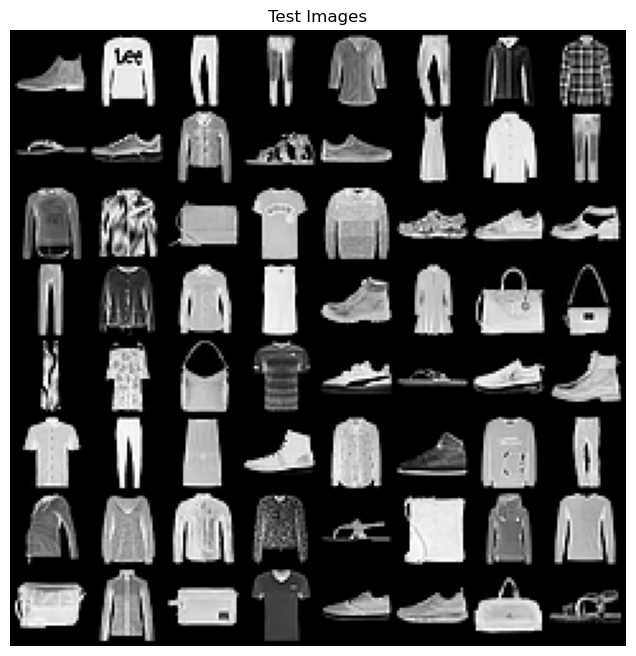

In [41]:
test_data_viz = next(iter(test_dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Test Images")
plt.imshow(np.transpose(vutils.make_grid(test_data_viz[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()